In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 

In [4]:
#读入文件数据 传统方法
data_raw = open('CDNOW.txt')
lines = data_raw.readlines()
data = []
for line in lines:
    data.append(re.split('\s+', line.strip()))
#print(data[-1]) 测试数据处理的完整和准确性
    

['23570', '19970326', '2', '42.96']


In [132]:
#读入文件数据，pandas方法
data = pd.read_table('CDNOW.txt', header=None, sep='\s+', converters={ 0: str})
#建立列索引
names = ['id', 'trade_date', 'num', 'total_price']
data.columns = names
print(data.head())

      id  trade_date  num  total_price
0  00001    19970101    1        11.77
1  00002    19970112    1        12.00
2  00002    19970112    5        77.00
3  00003    19970102    2        20.76
4  00003    19970330    2        20.76


                num   total_price
count  69659.000000  69659.000000
mean       2.410040     35.893648
std        2.333924     36.281942
min        1.000000      0.000000
25%        1.000000     14.490000
50%        2.000000     25.980000
75%        3.000000     43.700000
max       99.000000   1286.010000


[Text(0,0.5,'amount'),
 (0, 1250),
 Text(0.5,0,'purcharse price'),
 Text(0.5,1,'purcharse price of each order')]

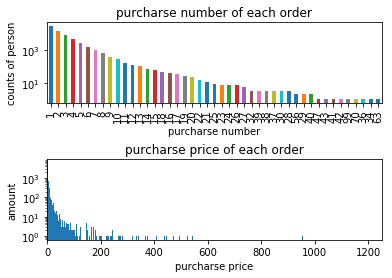

In [133]:
#订单购买数量，金额分析
analy_each_order = data[['num', 'total_price']].describe()
print(analy_each_order)
fig, axes = plt.subplots(2,1)
plt.subplots_adjust(hspace=0.7)
#分析订单数量
data['num'].value_counts().plot.bar(ax=axes[0], logy=True)
prop1={
    'xlabel': 'purcharse number', 
    'ylabel': 'counts of person',
    'title': 'purcharse number of each order'}
axes[0].set(**prop1) 
#分析订单金额
data['total_price'].value_counts().plot.hist(ax=axes[1], bins=1000, logy=True)
prop2={
    'xlabel': 'purcharse price', 
    'ylabel': 'amount',
    'xlim': [0,1250],
    'title': 'purcharse price of each order'}
axes[1].set(**prop2) 
#data['num'].value_counts().plot(xlim=[0,70],drawstyle='steps-post')

每笔交易的价格均值描述统计信息为
 count    69659.000000
mean        15.459447
std          8.735528
min          0.000000
25%         12.270000
50%         13.990000
75%         15.490000
max        305.990000
dtype: float64


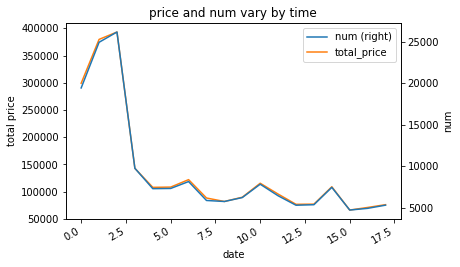

In [142]:
#订单数量趋势，金额趋势，异常值检测
from dateutil.parser import parse

ts = data.copy()

#将时间设为索引
ts['trade_date'] = ts['trade_date'].map(lambda x: parse(str(x)))
ts.index = ts['trade_date']
ts.drop('trade_date', axis=1, inplace=True)

#获取金额和购买数量的月度累计和
ts1 = ts[[ 'num', 'total_price']]
#将数据降采样到月，按月求和，分析变化趋势
ts_m = ts1.resample('M', kind='period').sum()
fig3 = ts_m.plot(use_index=False,y=['num','total_price'],secondary_y=['num'])
prop3={
    'xlabel': 'date', 
    'ylabel': 'total price',
    'title': 'price and num vary by time'}
fig3.set(**prop3) 
fig3.right_ax.set_ylabel('num')

#获取每个时间的单价变化情况
per_price = ts['total_price'] / ts['num']
per_price.index = ts.index
print('每笔交易的价格均值描述统计信息为\n',per_price.sort_index().describe())
#由于描述统计的结果中，单价的均值为15，最大值为305.因此我们认为至少超过100的单价记录是有问题的，标记为异常值
ts[per_price>100].to_csv('error_record.csv')

In [167]:
#分析各用户的购买状态

#01 各用户累积购买数量分析
data['num'].groupby(data['id']).sum().to_csv('各用户累计购买数量.csv')
data['num'].groupby(data['id']).max().to_csv('各用户单次最大购买数量.csv')
#apply方法
data1 = data.copy()
pur_analy = data['num'].groupby(data['id']).apply(lambda x: x / x.sum())
pur_analy.index = data1['id']
pur_analy.to_csv('各用户的购买贡献率.csv')

In [168]:
#分析各用户的购买金额
#02 各用户累积购买金额分析
data['total_price'].groupby(data['id']).sum().to_csv('各用户累计购买金额.csv')
data['total_price'].groupby(data['id']).max().to_csv('各用户单次最大金额.csv')
#apply方法

pur_analy = data['total_price'].groupby(data['id']).apply(lambda x: x / x.sum())
pur_analy.index = data1['id']
pur_analy.to_csv('各用户的购买金额贡献率.csv')

In [169]:
#03 各用户购买次数分析
data['num'].groupby(data['id']).count().to_csv('各用户累计购买次数.csv')

In [174]:
#用户第一次购买时间
data1 = data.copy()
data1['trade_date'] = data1['trade_date'].map(lambda x: parse(str(x)))
data1['trade_date'].groupby(data['id']).min().to_csv('各用户首次购买时间.csv')
data1['trade_date'].groupby(data['id']).max().to_csv('各用户最后一次购买时间.csv')

In [187]:
#时间间隔
from datetime import datetime
now = datetime.now()
group_time = data1['trade_date'].groupby(data['id'])

group_time.apply(lambda x: now - x.max()).to_csv('各用户最后一次购买与当前时间间隔.csv')

group_time.apply(lambda x: x.max() - x.min()).to_csv('各用户购买生命周期.csv')

#首次回购时间差，使用apply调用第二小的时间做减法。
def rebuy(se):
    if se.count() > 1:
        return se.sort_values().iloc[1] - se.min()
    else:
        return 0
group_time.apply(rebuy).to_csv('各用户首次回购周期.csv')

group_time.apply(lambda x: (x.max() - x.min()) / x.count()).to_csv('各用户平均购买时间.csv')

id
00001           0 days 00:00:00
00002           0 days 00:00:00
00003          85 days 04:00:00
00004          86 days 06:00:00
00005   33 days 08:43:38.181818
Name: trade_date, dtype: timedelta64[ns]

,id,trade_date,num,total_price
0,00001,1997-01-01,1,11.77
1,00002,1997-01-12,1,12.00
2,00002,1997-01-12,5,77.00
3,00003,1997-01-02,2,20.76
4,00003,1997-03-30,2,20.76


In [205]:
time_key = pd.TimeGrouper('M')
each_one_in_month = data1[['id', 'trade_date', 'num']].set_index('trade_date').groupby(['id', time_key])
each_one_in_month.count().to_csv('各用户各月的购买情况.csv')

C:\Users\HUAWEI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.
